In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects
import seaborn as sns
import numpy as np
import itertools
import scipy.stats
import statsmodels.stats.multitest
import statannotations.Annotator
import math
import os

import sys

sys.path.append('./../src/')
# from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams['pdf.fonttype'] = 42  # edit-able in illustrator
# mpl.rcParams['font.sans-serif'] = "Arial"
# mpl.rcParams["font.family"] = "sans-serif"


import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")

In [3]:
user = 'general'     # defines top hierarchy of output folder
outfolder = '12_covid_transitions'    # name of notebook

In [4]:
def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}.pdf',
    )

In [5]:
data = pd.read_csv(
    inout.get_material_path('general/05_join_clusters_umap/05_data_umap_clusters_220908_1554.csv.gz'), 
    index_col=0)

In [6]:
# Simplify discharge
data.Binary_outcome.replace({1: "Died", 0: 'Alive'}, inplace=True)

# Set discharge disposition order
data.Discharge_disposition = data.Discharge_disposition.astype("category")
data.Discharge_disposition = data.Discharge_disposition.cat.reorder_categories([
    'Home', 
    'Rehab', 
    'SNF', 
    'LTACH',
    'Hospice', 
    'Died'
])

data = data.rename(columns={
    'Patient_id': 'patient',
    'ICU_stay': 'stay',
    'ICU_day': 'day',
    'clusters': 'cluster'
})

# Ensure order
data.sort_values(["patient", "stay", "day"], inplace=True)

In [7]:
DISCHARGE_STACKS = [
    ('Home', 'Rehab', 'SNF', 'LTACH'),
    ('Hospice', 'Died')
]

In [8]:
DISCH_PALETTE = [
    "tab:blue", #home
    "lightseagreen", #rehab
    "beige", #snf
    "gold",#ltach
    "orange",#hospice
    "crimson",#died 
]

In [9]:
cluster_mortality = pd.read_csv(
    inout.get_material_path('general/04_clustering/Similarity-cluster_mortality_220908_1540.csv.gz'), 
    index_col=0
)

In [10]:
cluster_mortality['clusters'] = cluster_mortality['index'] + 1

In [11]:
cluster_mortality = cluster_mortality[['clusters', 'mortality']]

In [12]:
cluster_mortality = cluster_mortality.set_index("clusters")

In [13]:
def get_axes_pixel_transform(ax):
    t = ax.transAxes.transform([(0, 0), (1, 1)])
    return mpl.transforms.Affine2D().scale(1 / (t[1, 0] - t[0, 0]), 1 / (t[1, 1] - t[0, 1])) + ax.transAxes

In [14]:
def get_arrow_path(ax, tx, p0, i0, i1, p1, base_w=10):
    def get_dist(p0, p1):
        return ((p1[0] - p0[0]) ** 2 + (p1[1] - p0[1]) ** 2) ** 0.5
    base_h = 3
    head_w = 5
    head_h = 5
    points = np.array([p0, i0, i1, p1], dtype=float)
    (p0, i0, i1, p1) = tx.inverted().transform(ax.transData.transform(points))
    base_off = base_w / get_dist(p0, i0)
    base_hoff = base_h / get_dist(p0, i0)
    base_r = (p0[0] + base_off * (i0[1] - p0[1]), p0[1] - base_off * (i0[0] - p0[0]))
    base_m = (p0[0] + base_hoff * (i0[0] - p0[0]), p0[1] + base_hoff * (i0[1] - p0[1]))
    base_l = (p0[0] - base_off * (i0[1] - p0[1]), p0[1] + base_off * (i0[0] - p0[0]))
    head_off = head_w / get_dist(i1, p1)
    head_hoff = head_h / get_dist(i1, p1)
    head_r = (p1[0] + head_off * (p1[1] - i1[1]), p1[1] - head_off * (p1[0] - i1[0]))
    head_l = (p1[0] - head_off * (p1[1] - i1[1]), p1[1] + head_off * (p1[0] - i1[0]))
    head_r = (head_r[0] - head_hoff * (p1[0] - i1[0]), head_r[1] - head_hoff * (p1[1] - i1[1]))
    head_l = (head_l[0] - head_hoff * (p1[0] - i1[0]), head_l[1] - head_hoff * (p1[1] - i1[1]))
    verts = [base_r, i0, i1, p1, head_r, p1, head_l, p1, i1, i0, base_l, base_m, base_r]
    codes = [
        mpl.path.Path.MOVETO, mpl.path.Path.CURVE4, mpl.path.Path.CURVE4, mpl.path.Path.LINETO, 
        mpl.path.Path.LINETO, mpl.path.Path.LINETO, mpl.path.Path.LINETO, mpl.path.Path.LINETO, 
        mpl.path.Path.CURVE4, mpl.path.Path.CURVE4, mpl.path.Path.LINETO, mpl.path.Path.LINETO,
        mpl.path.Path.CLOSEPOLY
    ]
    return mpl.path.Path(verts, codes)

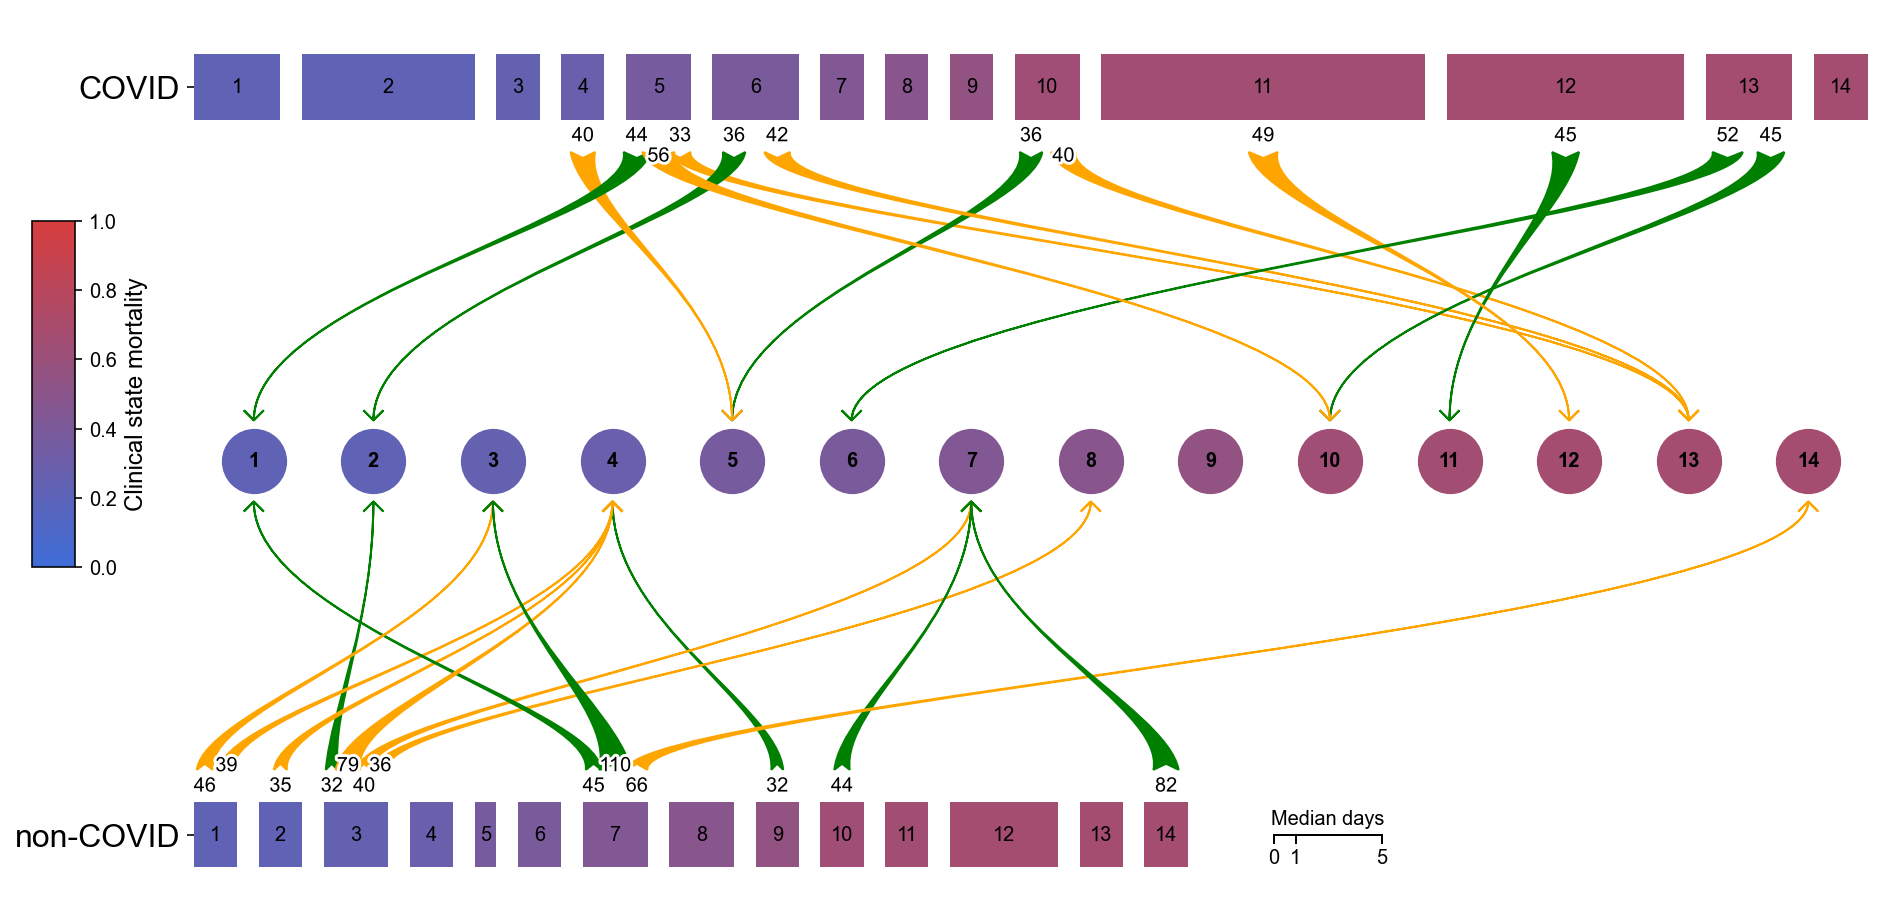

In [15]:
def roll_of_yarn2(df, cluster_sizes, names=None, only_show=None, threshold=0):
    if only_show is None:
        only_show = cluster_sizes.index.tolist()
    if names is None:
        names = {}
    cluster_order = cluster_sizes.index
    gap = 1
    blue_to_red = {
        "red": [
            (0.0, 62/256, 62/256),
            (1.0, 216/256, 216/256),
        ],
        "green": [
            (0.0, 109/256, 109/256),
            (1.0, 62/256, 62/256),
        ],
        "blue": [
            (0.0, 216/256, 216/256),
            (1.0, 62/256, 62/256),
        ]
    }
    mortality_cmap = mpl.colors.LinearSegmentedColormap("mort_cmaap", segmentdata=blue_to_red, N=256)
#     cdict = {
#         'red':   [
#             (0.0, 180/256, 180/256),
#             (0.2, 256/256, 256/256),
#             (1.0, 108/256, 108/256)
#         ],

#         'green': [
#             (0.0, 180/256, 180/256),
#             (0.2, 176/256, 176/256),
#             (1.0, 0/256, 0/256)
#         ],

#         'blue':  [
#             (0.0, 180/256, 180/256),
#             (0.2, 27/256, 27/256),
#             (1.0, 0/256, 0/256)
#         ]
#     }
    # min_mortality_diff = cluster_mortality.mortality.min() - cluster_mortality.mortality.max()
    # max_mortality_diff = cluster_mortality.mortality.max() - cluster_mortality.mortality.min()
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'exprCmap', 
        [DISCH_PALETTE[0], DISCH_PALETTE[-1]]
    )
    cmap = sns.cm.vlag
    lw = 1.5
    fig, ax = plt.subplots(figsize=(15, 8))
    tx = get_axes_pixel_transform(ax)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_yticks([0.4, 9.6])
    ax.set_yticklabels(["non-COVID", "COVID"], size=16)
    ax.set_ylim(-0.2, 10.5)
    ax.set_xticks([])
    # ax.set_xlabel("Clinical states", size=16)
    # ax.set_xlim(0, cluster_sizes.cumsum().iat[-1] + gap * (cluster_sizes.size - 1))
    data = df.copy()
    
    for covid in (True, False):
        df = data.loc[data.COVID_status == covid, :]
        cl_size = df.groupby(["patient", "cluster"]).agg({"day": "count"}).reset_index().groupby(
            "cluster"
        ).day.median()
            
        df = df.loc[df.is_transition, :].groupby(
            ["cluster", "next_cluster"], dropna=False
        ).agg({"day": "count"}).reset_index()
        df = df.loc[df.day > 0, :]
        df = df.reset_index()

        start = 0
        bottom = 9.2 if covid else 0
        # if not covid:
            # gap = (rightmost - cl_size.sum()) / (cl_size.size - 1)
            # start = (rightmost - cl_size.sum() - (cl_size.size - 1) * gap) / 2
            # non_covid_start = start
        # xticks = []
        for i, cluster_size in enumerate(cl_size.tolist()):
            this_name = cluster_order[i]
            this_color = mortality_cmap(cluster_mortality.mortality[this_name])
            ax.bar(start, 0.8, bottom=bottom, width=cluster_size, align="edge", color=this_color)
            # xticks.append(start + cluster_size / 2)
            # if covid:
            #     ax.scatter([start + cluster_size / 2], [5], s=1000, color=this_color, zorder=1000)
            #     ax.text(start + cluster_size / 2, 5, cluster_order[i], ha="center", va="center", weight="bold", zorder=1100)
            n_text = start + cluster_size / 2
            ax.text(
                n_text, 
                9.6 if covid else 0.4, 
                this_name, 
                ha="center", 
                va="center", 
                zorder=11
            )
            start += cluster_size + gap

        if covid:
            pad = 2
            start = 0
            rightmost = cl_size.sum() + gap * (cl_size.size - 1)
            ax.set_xlim(0, rightmost)
            sink_gap = (rightmost - start) / cl_size.size
            sink_pos = {}
            # ax.axvline(start, color="red", lw=1)
            # ax.axvline(rightmost, color="red", lw=1)
            for i, _ in enumerate(cl_size.tolist()):
                this_name = cluster_order[i]
                this_color = mortality_cmap(cluster_mortality.mortality[this_name])
                ax.scatter([start + sink_gap / 2], [5], s=1000, color=this_color, zorder=1000)
                ax.text(start + sink_gap / 2, 5, cluster_order[i], ha="center", va="center", weight="bold", zorder=1100)
                # ax.axvline(start + sink_gap / 2, color="red", lw=1)
                sink_pos[cluster_order[i]] = start + sink_gap / 2
                start += sink_gap
        # ax.set_xticks(xticks)
        # ax.set_xticklabels([names.get(x, x) for x in cluster_order.tolist()])
        
        max_out = 0
        for i, cluster_size in enumerate(cl_size.tolist()):
            this_name = cluster_order[i]
            if this_name not in only_show:
                continue
            df_slice = df.loc[df.cluster == this_name]
            df_slice = df_slice.loc[df_slice.day > threshold, :]
            if df_slice.size == 0:
                continue
            arrow_space = cluster_size / df_slice.shape[0]
            for j, (_, r) in enumerate(df_slice.iterrows()):
                r0 = 8.8 if covid else 1.2
                pct_txt = str(r.day)
                mort_diff = cluster_mortality.mortality[r.next_cluster] - cluster_mortality.mortality[r.cluster]
                # color = cmap(r.day / df.day.max())
                # color = cmap((mort_diff - min_mortality_diff) / (max_mortality_diff - min_mortality_diff))
                if mort_diff > 0:
                    color = "orange"
                else:
                    color = "green"
                lw = 0.0 + 8 * (r.day / df.day.max()) ** 0.8
                t0 = 0
                # if not covid:
                #     t0 += non_covid_start
                if i > 0:
                    t0 += cl_size.cumsum().iat[i - 1] + gap * i
                t0 += arrow_space / 2
                t0 += j * arrow_space
                next_cl = r.next_cluster
                next_cl_idx = cl_size.index.get_loc(next_cl)
                next_cl_pos = sink_pos[next_cl]
                # if next_cl_idx > 0:
                #     next_cl_pos += cluster_sizes.cumsum()[next_cl - 1] + gap * next_cl_idx
                # next_cl_pos += cluster_sizes[next_cl] / 2
                t1, r1 = (next_cl_pos, 5)
                r1 -= -0.5 if covid else 0.5
                r2 = 8 if covid else 2
                r3 = 7 if covid else 3
                path = get_arrow_path(ax, tx, (t0, r0), (t0, r2), (t1, r3), (t1, r1), base_w=lw)
                patch = mpl.patches.PathPatch(
                    path, 
                    fc=color, 
                    ec=color, 
                    lw=1,
                    transform=tx,
                    zorder=r.day
                )
                ax.add_patch(patch)
                if covid:
                    text_r = r0 + 0.2
                else:
                    text_r = r0 - 0.2
                path_effects = path_effects = [
                    mpl.patheffects.Stroke(linewidth=3, foreground="white"),
                    mpl.patheffects.Normal()
                ]
                if arrow_space < 2 and j % 2 == 1:
                    text_r += -0.25 if covid else 0.25
                # if arrow_space < 2 and j % 3 == 2:
                #     text_r += -0.5 if covid else 0.5
                ax.text(t0, text_r, pct_txt, ha="center", va="center", zorder=1000, path_effects=path_effects)
    # ax.set_xticks(range(0, int(rightmost), 5))
    cbar_ax = fig.add_axes((0.05, 0.4, 0.02, 0.3))
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(cmap=mortality_cmap), 
        cax=cbar_ax,
    )
    cbar.set_label("Clinical state mortality", size=12)
    return fig
fig = roll_of_yarn2(
    data, 
    pd.Series(8, index=sorted(data.cluster.unique())),
    threshold=30
)
ax = fig.axes[0]
ax.plot([50, 50], [0.3, 0.4], c="black", lw=1)
ax.plot([50, 55], [0.4, 0.4], c="black", lw=1)
ax.plot([51, 51], [0.3, 0.4], c="black", lw=1)
ax.plot([55, 55], [0.3, 0.4], c="black", lw=1)
ax.annotate("0", (50, 0.3), xytext=(0, -20), textcoords="offset pixels", ha="center")
ax.annotate("1", (51, 0.3), xytext=(0, -20), textcoords="offset pixels", ha="center")
ax.annotate("5", (55, 0.3), xytext=(0, -20), textcoords="offset pixels", ha="center")
ax.annotate("Median days", (52.5, 0.4), xytext=(0, 10), textcoords="offset pixels", ha="center")
dump_figure("covid-transitions-arrows")

In [16]:
df = data.copy()
df.loc[df.is_transition & df.next_cluster.lt(df.cluster), "favorable_transition"] = True
df.loc[df.is_transition & df.next_cluster.gt(df.cluster), "favorable_transition"] = False

In [17]:
df = df.groupby(["patient", "COVID_status"]).apply(
    lambda x: pd.Series(
        [
            x.favorable_transition.dropna().astype(bool).sum(), 
            (~x.favorable_transition.dropna().astype(bool)).sum()
        ],
        index=[True, False]
    )
).reset_index().dropna().melt(
    id_vars=["patient", "COVID_status"],
    var_name="favorable_transition",
    value_name="n_transitions"
)

In [18]:
df

,patient,COVID_status,favorable_transition,n_transitions
0,43,True,True,1
1,51,True,True,1
2,86,False,True,3
3,110,False,True,3
4,118,False,True,0
...,...,...,...,...
1165,9897,False,False,3
1166,9969,False,False,2
1167,9978,False,False,1
1168,9988,True,False,2


In [19]:
stat_results = []

days1 = df.n_transitions[df.favorable_transition & df.COVID_status]
days2 = df.n_transitions[df.favorable_transition & ~df.COVID_status]
if days1.size > 0 and days2.size > 0:
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append([True, True, False, days1.size, days2.size, pval])

days1 = df.n_transitions[~df.favorable_transition & df.COVID_status]
days2 = df.n_transitions[~df.favorable_transition & ~df.COVID_status]
if days1.size > 0 and days2.size > 0:
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append([False, True, False, days1.size, days2.size, pval])

stat_results = pd.DataFrame(stat_results, columns=["favorable_transition", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
    pairs.append(((r.favorable_transition, r.group1), (r.favorable_transition, r.group2)))

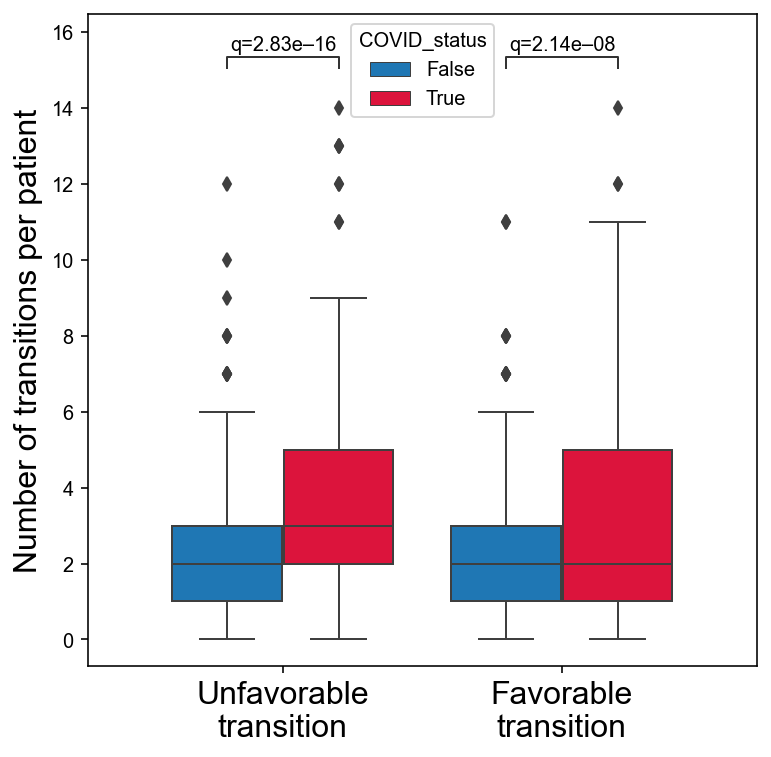

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(
    data=df, 
    x="favorable_transition", 
    hue="COVID_status",
    y="n_transitions", 
    saturation=1, 
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    linewidth=1,
    ax=ax
)
ax.set_ylabel("Number of transitions per patient", size=16)
ax.set_xlabel("")
ax.tick_params(axis="x", labelsize=14)
ax.set_xticklabels(["Unfavorable\ntransition", "Favorable\ntransition"], size=16)
# ax.legend(loc="upper left", title="Outcome", frameon=False, fontsize=14, title_fontsize=12)
# ax.legend_.set_bbox_to_anchor((1, 0.8))
# ax.set_title(f"Distribution of sum of transitions for first {day} days after episode", size=16)
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="favorable_transition",
    y="n_transitions", 
    hue="COVID_status",
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate();
dump_figure("covid-transitions-sum")

In [21]:
pt_info = data.groupby("patient").head(1).set_index("patient")

In [22]:
df.n_transitions /= pt_info.Cumulative_ICU_days[df.patient].values

In [23]:
stat_results = []

days1 = df.n_transitions[df.favorable_transition & df.COVID_status]
days2 = df.n_transitions[df.favorable_transition & ~df.COVID_status]
if days1.size > 0 and days2.size > 0:
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append([True, True, False, days1.size, days2.size, pval])

days1 = df.n_transitions[~df.favorable_transition & df.COVID_status]
days2 = df.n_transitions[~df.favorable_transition & ~df.COVID_status]
if days1.size > 0 and days2.size > 0:
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append([False, True, False, days1.size, days2.size, pval])

stat_results = pd.DataFrame(stat_results, columns=["favorable_transition", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
    pairs.append(((r.favorable_transition, r.group1), (r.favorable_transition, r.group2)))

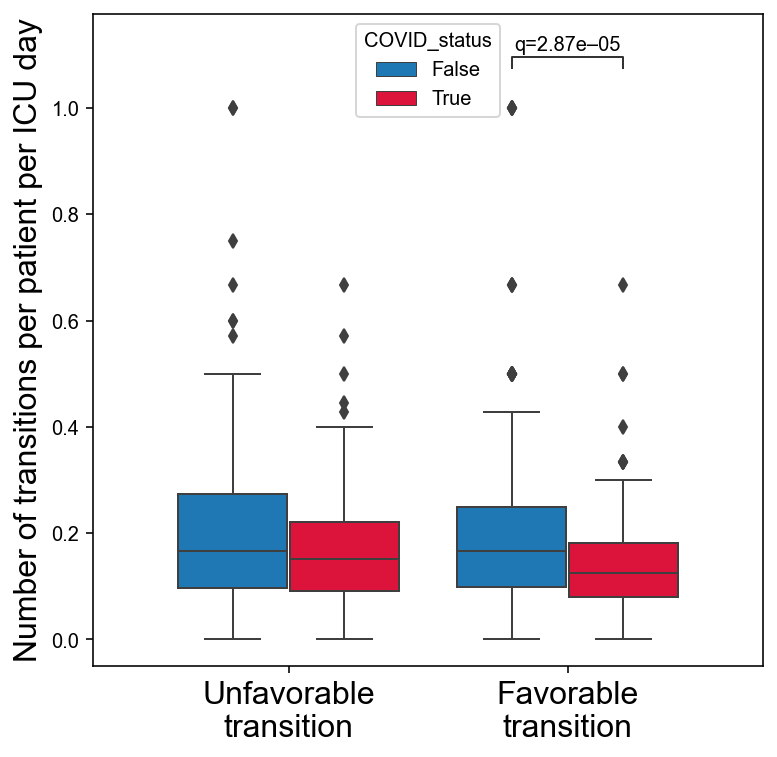

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(
    data=df, 
    x="favorable_transition", 
    hue="COVID_status",
    y="n_transitions", 
    saturation=1, 
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    linewidth=1,
    ax=ax
)
ax.set_ylabel("Number of transitions per patient per ICU day", size=16)
ax.set_xlabel("")
ax.tick_params(axis="x", labelsize=14)
ax.set_xticklabels(["Unfavorable\ntransition", "Favorable\ntransition"], size=16)
# ax.legend(loc="upper left", title="Outcome", frameon=False, fontsize=14, title_fontsize=12)
# ax.legend_.set_bbox_to_anchor((1, 0.8))
# ax.set_title(f"Distribution of sum of transitions for first {day} days after episode", size=16)
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="favorable_transition",
    y="n_transitions", 
    hue="COVID_status",
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate();
dump_figure("covid-transitions-sum-per-day")

In [26]:
df.groupby(["favorable_transition", "COVID_status"]).n_transitions.median()

favorable_transition  COVID_status
False                 False           0.166667
                      True            0.150581
True                  False           0.166667
                      True            0.124447
Name: n_transitions, dtype: float64